In this notebook, a very basic approach for solving NLP based problems is explained. Following topics are covered-
- Data Cleaning
- Tokenization
- Stopwords removal
- Lemmatization (With POS tagging)
- Bag of Words model
- Tf-Idf model
- Classification of tweets

The objective of this problem is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Wordcloud formation library
from wordcloud import WordCloud

# Text preprocessing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Text features formation and extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/test split 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# ML Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import time
import warnings
warnings.filterwarnings("ignore") 

SEED = 123

## Importing data

In [2]:
train = pd.read_csv('train.csv').set_index('id')
test = pd.read_csv('test.csv').set_index('id')
print(train.shape, test.shape)
train.head()

(31962, 2) (17197, 1)


,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [3]:
# Target value distribution (Imbalanced data)
train.label.value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

## Stepwise cleaning of the tweets in the train dataset

DIfferent steps involved in the preprocessing of the tweets-

Noise removal — stripping text of formatting (e.g., HTML tags).

Tokenization — breaking text into individual words.

Normalization — cleaning text data in any other way:

- Stemming is a blunt axe to chop off word prefixes and suffixes. “booing” and “booed” become “boo”, but “sing” may become “s” and “sung” would remain “sung.”

- Lemmatization is a scalpel to bring words down to their root forms. For example, NLTK’s savvy lemmatizer knows “am” and “are” are related to “be.”
Other common tasks include lowercasing, stopwords removal, spelling correction, etc.

Noise removal: Following things has to remove from the tweets first-
- @
- #
- Links

In [4]:
# Removing unwanted words/patterns from tweets
def remove_unwanted_patterns(row):
    s = re.sub(r'@[\w]* ','',row['tweet']).lower()   # Removing @user
    s = re.sub(r'#','',s)                            # Removing #
    s = re.sub(r'\s{2,}',' ',s)                      # Removing extra spaces
    s = re.sub(r'[^a-zA-Z#]',' ',s)                   # Removing unwanted words/chatracters
    return s

train['cleaned_tweets'] = train.apply(remove_unwanted_patterns, axis=1)
train.head()

,label,tweet,cleaned_tweets
id,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
3,0,bihday your majesty,bihday your majesty
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...
5,0,factsguide: society now #motivation,factsguide society now motivation


After noise removal, these 3 basic steps are carried out
- Tokenize
- Stopwords removal
- Normalize: Stemming or Lemmatization

In [5]:
# Tokenizing the tweets
from nltk.tokenize import word_tokenize
train['tokenized'] = train['cleaned_tweets'].apply(lambda x: word_tokenize(x))
train.head()

,label,tweet,cleaned_tweets,tokenized
id,,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...,"[when, a, father, is, dysfunctional, and, is, ..."
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,"[thanks, for, lyft, credit, i, can, t, use, ca..."
3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]"
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...,"[model, i, love, u, take, with, u, all, the, t..."
5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]"


In [6]:
# Removing stopwords from tweets
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
train['removed_stopwords'] = train['tokenized'].apply(lambda x:[word for word in x if word not in stop_words])
train.head()

,label,tweet,cleaned_tweets,tokenized,removed_stopwords
id,,,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...,"[when, a, father, is, dysfunctional, and, is, ...","[father, dysfunctional, selfish, drags, kids, ..."
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,"[thanks, for, lyft, credit, i, can, t, use, ca...","[thanks, lyft, credit, use, cause, offer, whee..."
3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]"
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, u, take, u, time, ur]"
5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]"


In [7]:
# Normalizing the tweets
from collections import Counter
from nltk.corpus import wordnet

def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

from nltk.stem import WordNetLemmatizer
normalizer = WordNetLemmatizer()
train['normalized'] = train['removed_stopwords'].apply(lambda row:[normalizer.lemmatize(token, get_part_of_speech(token)) 
                                                  for token in row])
train.head()

,label,tweet,cleaned_tweets,tokenized,removed_stopwords,normalized
id,,,,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...,"[when, a, father, is, dysfunctional, and, is, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drag, kid, dy..."
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,"[thanks, for, lyft, credit, i, can, t, use, ca...","[thanks, lyft, credit, use, cause, offer, whee...","[thanks, lyft, credit, use, cause, offer, whee..."
3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]"
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, u, take, u, time, ur]","[model, love, u, take, u, time, ur]"
5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]"


In [8]:
# Converting the list to string
train['words_from_tweet'] = train['normalized'].apply(lambda row: " ".join(row))
train.head()

,label,tweet,cleaned_tweets,tokenized,removed_stopwords,normalized,words_from_tweet
id,,,,,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...,"[when, a, father, is, dysfunctional, and, is, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drag, kid, dy...",father dysfunctional selfish drag kid dysfunct...
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,"[thanks, for, lyft, credit, i, can, t, use, ca...","[thanks, lyft, credit, use, cause, offer, whee...","[thanks, lyft, credit, use, cause, offer, whee...",thanks lyft credit use cause offer wheelchair ...
3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]",bihday majesty
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, u, take, u, time, ur]","[model, love, u, take, u, time, ur]",model love u take u time ur
5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]",factsguide society motivation


## Function to preprocess tweets

In [9]:
# Function for removing unwanted patterns from text
def remove_unwanted_patterns(row):
    s = re.sub(r'@[\w]* ','',row['tweet']).lower()   # Removing @user
    s = re.sub(r'#','',s)                            # Removing #
    s = re.sub(r'\s{2,}',' ',s)                      # Removing extra spaces
    s = re.sub(r'[^a-zA-Z]',' ',s)                   # Removing unwanted words/chatracters
    return s

# Function for part of speech tagging
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech


def apply_df(df):
    # Hashtags
    df['hashtags'] = df['tweet'].apply(lambda row: re.findall(r'#[\w]*',row))
    df['hashtags'] = df['hashtags'].apply(lambda row: re.sub('#', '', " ".join(row)))
    
    # Removing unwanted words/patterns from tweets
    df['cleaned_tweets'] = df.apply(remove_unwanted_patterns, axis=1)

    # Tokenizing the tweets
    df['tokenized'] = df['cleaned_tweets'].apply(lambda x: word_tokenize(x))

    # Removing stopwords from tweets
    stop_words = set(stopwords.words('english'))
    df['removed_stopwords'] = df['tokenized'].apply(lambda row: [word for word in row if word not in stop_words])

    # Normalizing the tweets
    normalizer = WordNetLemmatizer()
    df['normalized'] = df['removed_stopwords'].apply(lambda row:[normalizer.lemmatize(token, get_part_of_speech(token)) 
                                                      for token in row])
    
    # Converting the list to string
    df['words_from_tweet'] = df['normalized'].apply(lambda row: str(" ".join(row)))

    return df

In [10]:
train = apply_df(train)
train.head()

,label,tweet,cleaned_tweets,tokenized,removed_stopwords,normalized,words_from_tweet,hashtags
id,,,,,,,,
1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...,"[when, a, father, is, dysfunctional, and, is, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drag, kid, dy...",father dysfunctional selfish drag kid dysfunct...,run
2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,"[thanks, for, lyft, credit, i, can, t, use, ca...","[thanks, lyft, credit, use, cause, offer, whee...","[thanks, lyft, credit, use, cause, offer, whee...",thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]",bihday majesty,
4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur ...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, u, take, u, time, ur]","[model, love, u, take, u, time, ur]",model love u take u time ur,model
5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]",factsguide society motivation,motivation


In [11]:
test = apply_df(test)
test.head()

,tweet,hashtags,cleaned_tweets,tokenized,removed_stopwords,normalized,words_from_tweet
id,,,,,,,
31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,studiolife aislife requires passion dedication...,"[studiolife, aislife, requires, passion, dedic...","[studiolife, aislife, requires, passion, dedic...","[studiolife, aislife, require, passion, dedica...",studiolife aislife require passion dedication ...
31964,@user #white #supremacists want everyone to s...,white supremacists birdsâ movie,white supremacists want everyone to see the n...,"[white, supremacists, want, everyone, to, see,...","[white, supremacists, want, everyone, see, new...","[white, supremacist, want, everyone, see, new,...",white supremacist want everyone see new bird m...
31965,safe ways to heal your #acne!! #altwaystohe...,acne altwaystoheal healthy healing,safe ways to heal your acne altwaystoheal he...,"[safe, ways, to, heal, your, acne, altwaystohe...","[safe, ways, heal, acne, altwaystoheal, health...","[safe, way, heal, acne, altwaystoheal, healthy...",safe way heal acne altwaystoheal healthy heal
31966,is the hp and the cursed child book up for res...,harrypotter pottermore favorite,is the hp and the cursed child book up for res...,"[is, the, hp, and, the, cursed, child, book, u...","[hp, cursed, child, book, reservations, alread...","[hp, curse, child, book, reservation, already,...",hp curse child book reservation already yes ha...
31967,"3rd #bihday to my amazing, hilarious #nephew...",bihday nephew,rd bihday to my amazing hilarious nephew el...,"[rd, bihday, to, my, amazing, hilarious, nephe...","[rd, bihday, amazing, hilarious, nephew, eli, ...","[rd, bihday, amaze, hilarious, nephew, eli, ah...",rd bihday amaze hilarious nephew eli ahmir unc...


## Visualising most used words in the tweets

Text(0.5, 1.0, 'Test dataset')

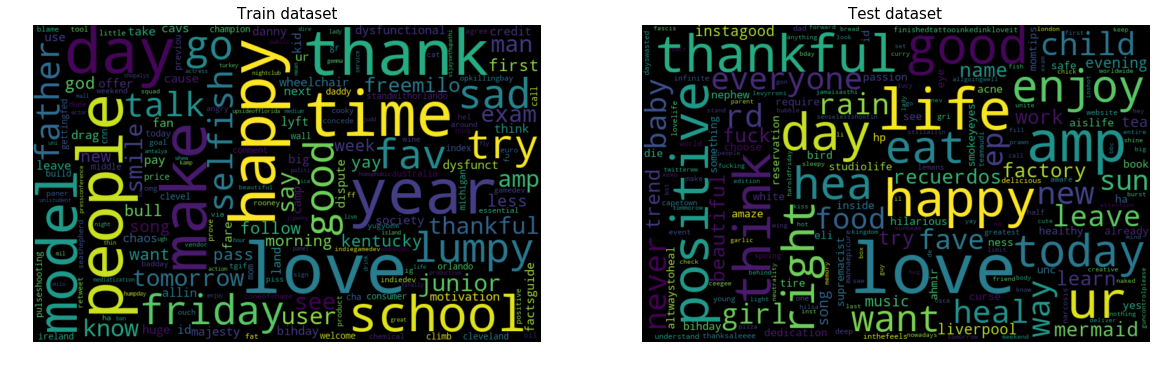

In [12]:
plt.figure(figsize=(20, 14))

wordcloud_train = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(train['words_from_tweet']))
plt.subplot(1,2,1)
plt.imshow(wordcloud_train, interpolation="bilinear")
plt.axis('off')
plt.title("Train dataset", fontsize=15)

wordcloud_test = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(test['words_from_tweet']))
plt.subplot(1,2,2)
plt.imshow(wordcloud_test, interpolation="bilinear")
plt.axis('off')
plt.title("Test dataset", fontsize=15)

Text(0.5, 1.0, 'Most used words in non racist/sexist tweets')

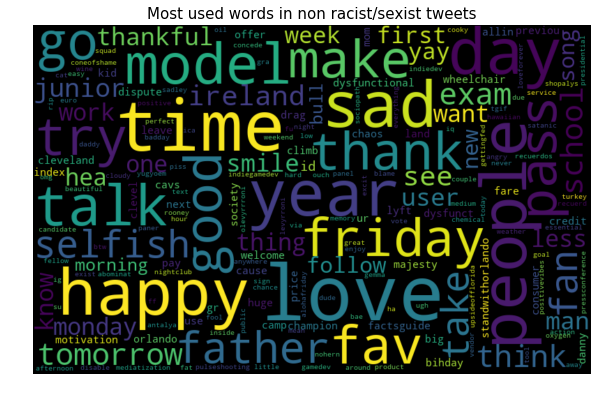

In [13]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).\
                                            generate(str(train[train.label==0]['words_from_tweet']))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most used words in non racist/sexist tweets", fontsize=15)

Text(0.5, 1.0, 'Most used words in racist/sexist tweets')

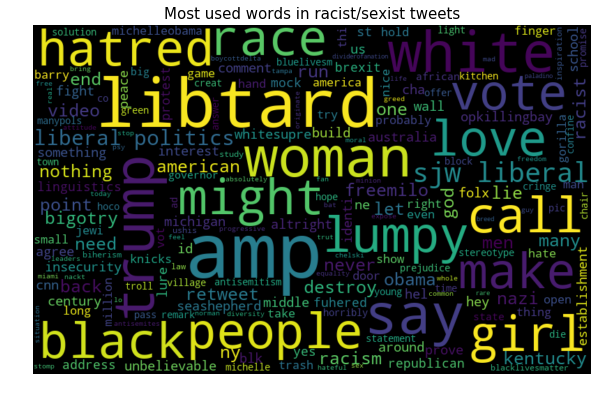

In [14]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).\
                                            generate(str(train[train.label==1]['words_from_tweet']))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most used words in racist/sexist tweets", fontsize=15)

## Bag of Words Model

In [15]:
vectorizer = CountVectorizer()
train_matrix_bow = vectorizer.fit_transform(train['words_from_tweet'])
test_matrix_bow = vectorizer.transform(test['words_from_tweet'])

X_train, X_test, y_train, y_test = train_test_split(train_matrix_bow, train.label, test_size = 1/3, random_state = SEED)

### Trying different models for classification

In [17]:
print("Naive Bayes")
nb = MultinomialNB()
nb.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, nb.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, nb.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, nb.predict(X_test)))

print("\nLogistic Regression")
logreg = LogisticRegression(class_weight='balanced' ,random_state=SEED)
logreg.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, logreg.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, logreg.predict(X_test)))

print("\nRandom Forest")
rf = RandomForestClassifier(n_estimators=100, max_depth=7, class_weight='balanced', random_state=SEED)
rf.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, rf.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, rf.predict(X_test)))

print("\nXG Boost")
xgb_ = xgb.XGBClassifier(random_state=SEED)
xgb_.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, xgb_.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, xgb_.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, xgb_.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, xgb_.predict(X_test)))

Naive Bayes
AUC score (train):  0.9669519707339623
AUC score (test):  0.9156251874226455
F1 score (train):  0.7595818815331009
F1 score (test):  0.5735294117647058

Logistic Regression
AUC score (train):  0.9985193594914614
AUC score (test):  0.9442452387832658
F1 score (train):  0.9015449863677674
F1 score (test):  0.669549104385423

Random Forest
AUC score (train):  0.931004764188662
AUC score (test):  0.9064529276098774
F1 score (train):  0.6001729605073509
F1 score (test):  0.5507584597432906

XG Boost
AUC score (train):  0.9477189893767146
AUC score (test):  0.9194391360293115
F1 score (train):  0.6140116019634092
F1 score (test):  0.5071770334928228


## Tf-Idf approach

In [18]:
vectorizer = TfidfVectorizer()
train_matrix_tfidf = vectorizer.fit_transform(train['words_from_tweet'])
test_matrix_tfidf = vectorizer.transform(test['words_from_tweet'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split\
        (train_matrix_tfidf, train.label, test_size = 1/3, random_state = SEED)

### Using different models with Tf-Idf approach for classification

In [19]:
print("Naive Bayes")
nb = MultinomialNB()
nb.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, nb.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, nb.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, nb.predict(X_test)))

print("\nLogistic Regression")
logreg = LogisticRegression(class_weight='balanced' ,random_state=SEED)
logreg.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, logreg.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, logreg.predict(X_test)))

print("\nRandom Forest")
rf = RandomForestClassifier(n_estimators=100, max_depth=7, class_weight='balanced', random_state=SEED)
rf.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, rf.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, rf.predict(X_test)))

print("\nXG Boost")
xgb_ = xgb.XGBClassifier(random_state=SEED)
xgb_.fit(X_train,y_train)
print("AUC score (train): ",roc_auc_score(y_train, xgb_.predict_proba(X_train)[:,1]))
print("AUC score (test): ",roc_auc_score(y_test, xgb_.predict_proba(X_test)[:,1]))
print("F1 score (train): ",f1_score(y_train, xgb_.predict(X_train)))
print("F1 score (test): ",f1_score(y_test, xgb_.predict(X_test)))

Naive Bayes
AUC score (train):  0.9480426011136251
AUC score (test):  0.8934805543893702
F1 score (train):  0.25450319581638586
F1 score (test):  0.19732034104750304

Logistic Regression
AUC score (train):  0.9951137720307758
AUC score (test):  0.9526600384932038
F1 score (train):  0.809031556039173
F1 score (test):  0.6576787807737398

Random Forest
AUC score (train):  0.9366966263837788
AUC score (test):  0.9034035952434176
F1 score (train):  0.5972181118674165
F1 score (test):  0.5576923076923077

XG Boost
AUC score (train):  0.9585132072716535
AUC score (test):  0.9165495559105605
F1 score (train):  0.6434245366284203
F1 score (test):  0.534195933456562


In [20]:
# Function to make submission file
# Takes the prediction result of the test data and output file name as argument
def make_sub_file(prediction_list, op_file_name = 'submission.csv'):
    sub = pd.read_csv('sample_submission.csv')
    sub['label'] = prediction_list
    sub.to_csv(op_file_name, index=False)
    print(sub.label.value_counts(normalize=True))
    del sub